In [5]:
import numpy as np
from numpy.linalg import inv, cholesky, LinAlgError
from joblib import Parallel, delayed
import seaborn as sns
from scipy import stats

def omega_bootstrap(A, replicates=1000, samples_per_replicate=10000,
                    use_chol_decomp=False, n_jobs=-1, seed=None):
    """
    Estima Omega(A): proporción de vectores factibles dentro de la esfera unitaria.
    Usa muestreo Monte Carlo desde N(0, Σ) y evalúa cuántos caen en el ortante positivo.

    Parameters:
        A : np.ndarray
            Matriz de interacciones (SxS)
        replicates : int
            Número de estimaciones independientes
        samples_per_replicate : int
            Número de muestras por estimación
        use_chol_decomp : bool
            Si True, usa Cholesky para invertir AᵀA
        n_jobs : int
            Número de procesos paralelos para usar
        seed : int or None
            Semilla para reproducibilidad

    Returns:
        np.ndarray
            Estimaciones de Omega (longitud = replicates)
    """
    A = np.array(A)
    S = A.shape[0]

    if A.shape[1] != S:
        raise ValueError("La matriz A debe ser cuadrada (SxS)")

    try:
        AtA = A.T @ A
        if use_chol_decomp:
            L = cholesky(AtA)
            Sigma = inv(L.T) @ inv(L)
        else:
            Sigma = inv(AtA)
    except LinAlgError:
        raise ValueError("No se pudo invertir AᵀA. Puede no ser positiva definida.")

    if seed is not None:
        np.random.seed(seed)

    # Factor de descomposición para muestreo
    L = cholesky(Sigma)

    def estimate():
        Z = np.random.randn(samples_per_replicate, S)  # muestras estándar
        X = Z @ L.T  # transformación para obtener covarianza Σ
        is_positive = (X > 0).all(axis=1)
        return np.mean(is_positive)

    results = Parallel(n_jobs=n_jobs)(delayed(estimate)() for _ in range(replicates))

    return np.array(results)


In [6]:
if __name__ == "__main__":
    A = -np.diag([1, 1, 1])  # mismo ejemplo que en R
    estimates = omega_bootstrap(A, replicates=1000, samples_per_replicate=10000, seed=42)
    print(f"Ω(A) media: {np.mean(estimates):.6f}")


Ω(A) media: 0.125049


In [7]:
import pandas as pd

In [8]:
def calculateC(name):
    A = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,1:].astype(np.float64)
    B = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B.csv').to_numpy()[:,1:].astype(np.float64)
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()

    C = A[:,:,np.newaxis] + B[:,:,np.newaxis] * P.T

    return -C

def giveP(name):
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
    return P.transpose()[0]

def calculateOmegas(C):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    for t in range(temporal):
        Omegas[t] = np.mean(omega_bootstrap(C[:,:,t], replicates=1000, samples_per_replicate=10000, seed=42))
    return Omegas

def plotOmegas(name,Omegas):
    plt.plot(Omegas)
    plt.scatter(range(len(Omegas)), Omegas, edgecolors='black',s=50)
    plt.title(name)
    plt.xlabel('Years')
    plt.ylabel('Feasibility Domain')
    plt.show()

In [ ]:
OmegasBEEFUN = calculateOmegas(calculateC('BEEFUN'))
plotOmegas('BEEFUN',OmegasBEEFUN)

FileNotFoundError: [Errno 2] No such file or directory: 'complexity72h-2025-main/data/BEEFUN/matrix_A.csv'

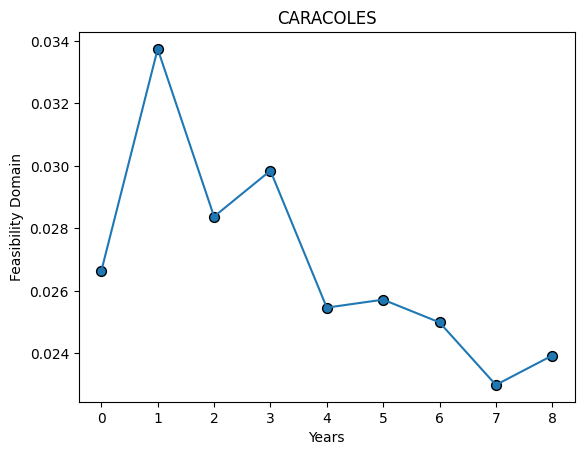

In [ ]:
OmegasCARACOLES = calculateOmegas(calculateC('CARACOLES'))
plotOmegas('CARACOLES',OmegasCARACOLES)

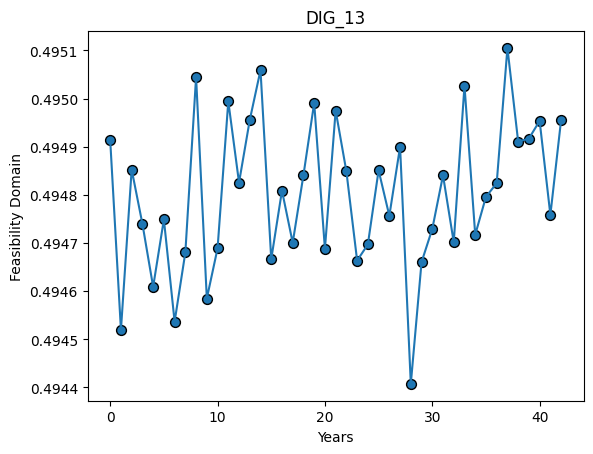

In [ ]:
OmegasDIG_13 = calculateOmegas(calculateC('DIG_13'))
plotOmegas('DIG_13',OmegasDIG_13)

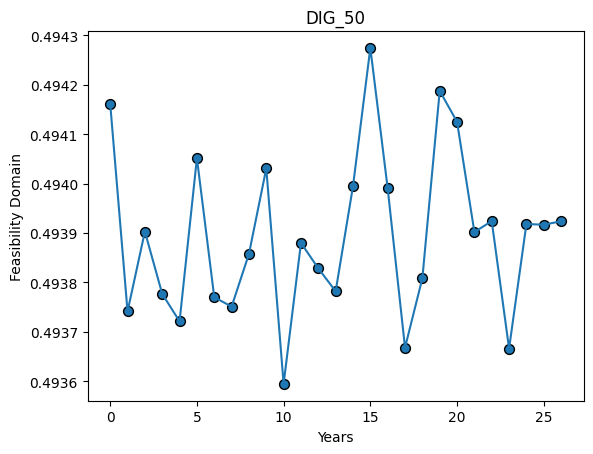

In [ ]:
OmegasDIG_50 = calculateOmegas(calculateC('DIG_50'))
plotOmegas('DIG_50',OmegasDIG_50)

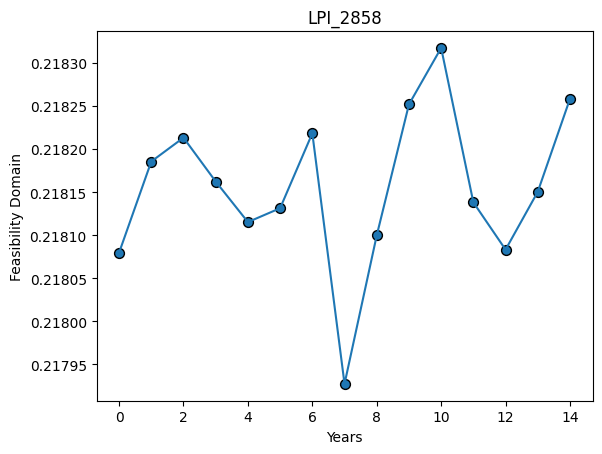

In [ ]:
OmegasLPI_2858 = calculateOmegas(calculateC('LPI_2858'))
plotOmegas('LPI_2858',OmegasLPI_2858)

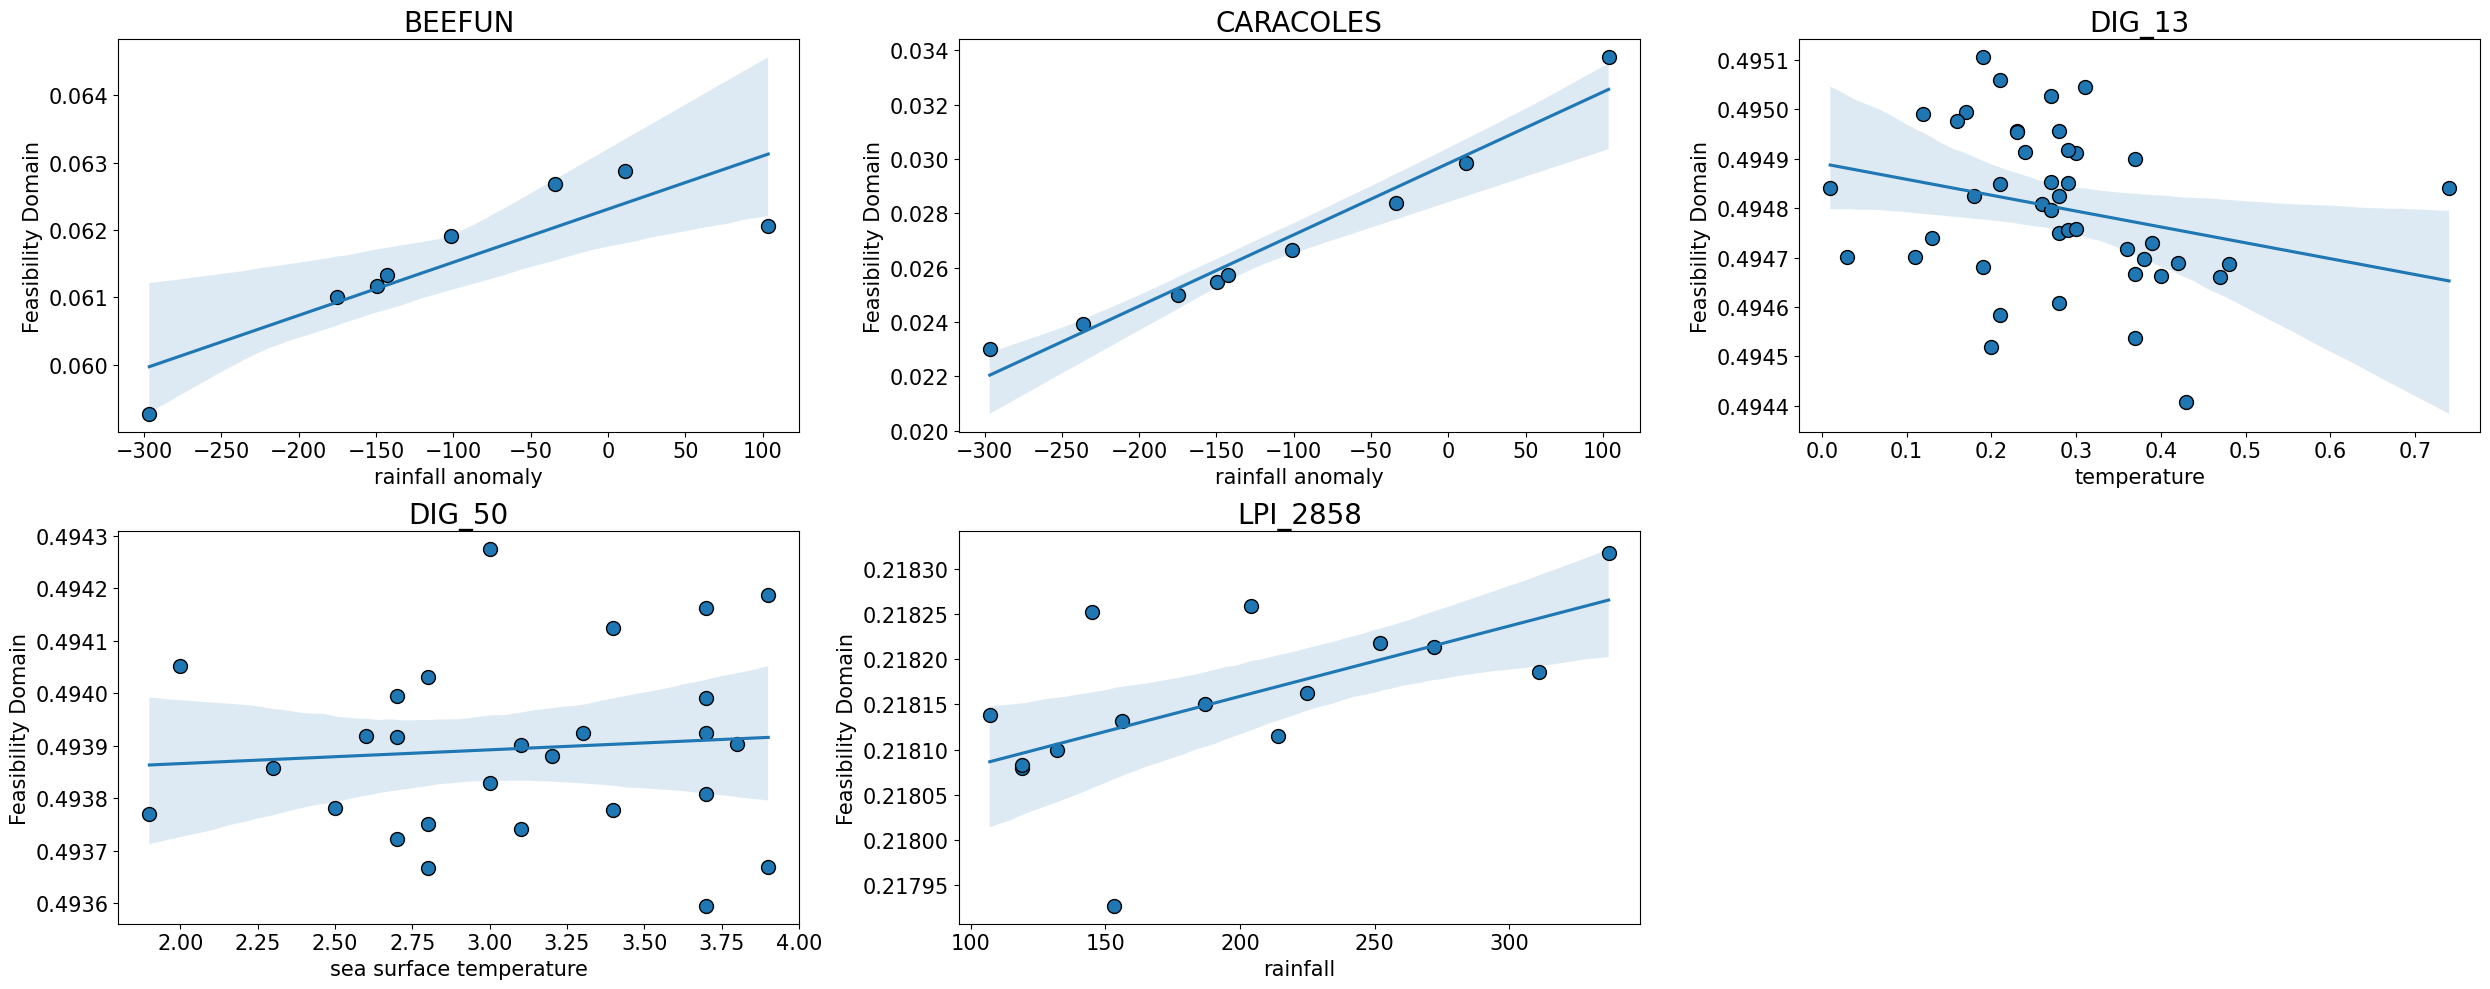

In [ ]:
PBEEFUN = giveP('BEEFUN')
PCARACOLES = giveP('CARACOLES')
PDIG_13 = giveP('DIG_13')
PDIG_50 = giveP('DIG_50')
PLPI_2858 = giveP('LPI_2858')

plt.figure(figsize=(25,10))

plt.subplot(2,3,1)
sns.regplot(x=PBEEFUN, y=OmegasBEEFUN, ci=95)
plt.scatter(PBEEFUN, OmegasBEEFUN, edgecolors='black', s=100)
plt.xlabel('rainfall anomaly',fontsize=15)
plt.ylabel('Feasibility Domain',fontsize=15)
plt.title('BEEFUN',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.subplot(2,3,2)
sns.regplot(x=PCARACOLES, y=OmegasCARACOLES, ci=95)
plt.scatter(PCARACOLES, OmegasCARACOLES, edgecolors='black', s=100)
plt.xlabel('rainfall anomaly',fontsize=15)
plt.ylabel('Feasibility Domain',fontsize=15)
plt.title('CARACOLES',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,3,3)
sns.regplot(x=PDIG_13, y=OmegasDIG_13, ci=95)
plt.scatter(PDIG_13, OmegasDIG_13, edgecolors='black', s=100)
plt.xlabel('temperature',fontsize=15)
plt.ylabel('Feasibility Domain',fontsize=15)
plt.title('DIG_13',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,3,4)
sns.regplot(x=PDIG_50, y=OmegasDIG_50, ci=95)
plt.scatter(PDIG_50, OmegasDIG_50, edgecolors='black', s=100)
plt.xlabel('sea surface temperature',fontsize=15)
plt.ylabel('Feasibility Domain',fontsize=15)
plt.title('DIG_50',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,3,5)
sns.regplot(x=PLPI_2858, y=OmegasLPI_2858, ci=95)
plt.scatter(PLPI_2858, OmegasLPI_2858, edgecolors='black', s=100)
plt.xlabel('rainfall',fontsize=15)
plt.ylabel('Feasibility Domain',fontsize=15)
plt.title('LPI_2858',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()

# Get the numbers of the linear regressions

In [ ]:
def linearstats(x,y,name):

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    dflinear = pd.DataFrame({
        'dataset':[name],
        'slope':[slope],
        'intercept':[intercept],
        'r_value':[r_value],
        'p_value':[p_value],
        'std_err':[std_err],
    })

    return dflinear

In [ ]:
dfstatscorrelation = pd.concat([
    linearstats(PBEEFUN, OmegasBEEFUN, 'BEEFUN'),
    linearstats(PCARACOLES, OmegasCARACOLES, 'CARACOLES'),
    linearstats(PDIG_13, OmegasDIG_13, 'DIG_13'),
    linearstats(PDIG_50, OmegasDIG_50, 'DIG_50'),
    linearstats(PLPI_2858, OmegasLPI_2858, 'LPI_2858'),
])

dfstatscorrelation

,dataset,slope,intercept,r_value,p_value,std_err
0,BEEFUN,7.886303e-06,0.062310,0.853943,0.006961,1.961907e-06
0,CARACOLES,2.626531e-05,0.029837,0.980230,0.000004,2.003835e-06
0,DIG_13,-3.211243e-04,0.494890,-0.261640,0.090113,1.850027e-04
0,DIG_50,2.627874e-05,0.493813,0.088749,0.659789,5.898651e-05
0,LPI_2858,7.770688e-07,0.218003,0.599696,0.018124,2.875876e-07


In [ ]:
dfstatscorrelation.to_csv('CorrelationStats_Omega_P.csv')

In [ ]:
def exportomegas(P,Omega,name):
    dfFD = pd.DataFrame({
        'P':P,
        'Omega':Omega,
    })
    dfFD.to_csv(name+'_omegas_env.csv')

In [ ]:
exportomegas(PBEEFUN, OmegasBEEFUN, 'BEEFUN')
exportomegas(PCARACOLES, OmegasCARACOLES, 'CARACOLES')
exportomegas(PDIG_13, OmegasDIG_13, 'DIG_13')
exportomegas(PDIG_50, OmegasDIG_50, 'DIG_50')
exportomegas(PLPI_2858, OmegasLPI_2858, 'LPI_2858')

In [ ]:
intercept

np.float64(0.06224923708769446)